In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [132]:
# Load the dataset
data = pd.read_csv('recode.csv')

# Inspect the first few rows
data.head()


,show_id,timestamp,section_id,availability_standard,availability_resale,capacity,event_date,venue_id,event_time_zone
0,4551330,2024_05_01T21_06_41,206,892,24,400,2024-12-13 20:00:00.000 Z,267,America/Los_Angeles
1,4551330,2024_05_01T21_06_41,207,1110,0,419,2024-12-13 20:00:00.000 Z,267,America/Los_Angeles
2,4551330,2024_05_01T21_06_41,208,924,2,314,2024-12-13 20:00:00.000 Z,267,America/Los_Angeles
3,4551330,2024_05_01T21_06_41,209,18,0,182,2024-12-13 20:00:00.000 Z,267,America/Los_Angeles
4,4551330,2024_05_02T09_06_55,102,473,0,234,2024-12-13 20:00:00.000 Z,267,America/Los_Angeles


In [133]:
# Summary of the dataset
data.info()

# Basic statistics of the numerical columns
data.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4132885 entries, 0 to 4132884
Data columns (total 9 columns):
 #   Column                 Dtype 
---  ------                 ----- 
 0   show_id                int64 
 1   timestamp              object
 2   section_id             object
 3   availability_standard  int64 
 4   availability_resale    int64 
 5   capacity               int64 
 6   event_date             object
 7   venue_id               int64 
 8   event_time_zone        object
dtypes: int64(5), object(4)
memory usage: 283.8+ MB


,show_id,availability_standard,availability_resale,capacity,venue_id
count,4.132885e+06,4.132885e+06,4.132885e+06,4.132885e+06,4.132885e+06
mean,4.829854e+06,1.566541e+02,1.763831e+01,3.659023e+02,1.049756e+04
std,1.499810e+05,9.115976e+02,2.802916e+02,1.188579e+03,9.242035e+03
min,4.217851e+06,0.000000e+00,0.000000e+00,0.000000e+00,9.000000e+00
25%,4.780388e+06,4.000000e+00,0.000000e+00,8.900000e+01,8.680000e+02
50%,4.861385e+06,2.700000e+01,0.000000e+00,2.090000e+02,1.144500e+04
75%,4.934185e+06,1.180000e+02,9.000000e+00,3.510000e+02,2.185300e+04
max,5.060180e+06,8.670400e+04,7.463200e+04,1.000000e+05,2.908400e+04


In [134]:
# Check for missing values in each column
data.isnull().sum()


show_id                  0
timestamp                0
section_id               0
availability_standard    0
availability_resale      0
capacity                 0
event_date               0
venue_id                 0
event_time_zone          0
dtype: int64

In [135]:
# Replace the underscores with correct delimiters for date and time
data['timestamp'] = data['timestamp'].str.replace('_', ':')  # Replace the third underscore with colon
data['timestamp'] = data['timestamp'].str.replace(':', '-', 2)  # Only replace the first two underscores with dashes
data['timestamp'] = data['timestamp'].str.replace('T', ' ', 1)  # Replace the third underscore with colon




In [136]:
# Convert the corrected string to datetime
data['timestamp'] = pd.to_datetime(data['timestamp'],utc=True)

In [137]:
# Convert event_date to datetime if necessary
data['event_date'] = pd.to_datetime(data['event_date'])

# Calculate time until event (in days)
data['days_until_event'] = (data['event_date'] - data['timestamp']).dt.days
data['hours_until_event'] = (data['event_date'] - data['timestamp']).dt.total_seconds() / 3600


In [138]:
data[['timestamp', 'event_date', 'days_until_event', 'hours_until_event']]

,timestamp,event_date,days_until_event,hours_until_event
0,2024-05-01 21:06:41+00:00,2024-12-13 20:00:00+00:00,225,5422.888611
1,2024-05-01 21:06:41+00:00,2024-12-13 20:00:00+00:00,225,5422.888611
2,2024-05-01 21:06:41+00:00,2024-12-13 20:00:00+00:00,225,5422.888611
3,2024-05-01 21:06:41+00:00,2024-12-13 20:00:00+00:00,225,5422.888611
4,2024-05-02 09:06:55+00:00,2024-12-13 20:00:00+00:00,225,5410.884722
...,...,...,...,...
4132880,2024-06-05 21:16:43+00:00,2024-06-06 20:00:00+00:00,0,22.721389
4132881,2024-06-05 21:16:43+00:00,2024-06-06 20:00:00+00:00,0,22.721389
4132882,2024-06-05 21:16:43+00:00,2024-06-06 20:00:00+00:00,0,22.721389
4132883,2024-06-06 09:16:10+00:00,2024-06-06 20:00:00+00:00,0,10.730556


In [139]:
data['days_until_event'].describe().astype(int)

count    4132885
mean         462
std         3193
min           -1
25%           43
50%           84
75%          125
max        27613
Name: days_until_event, dtype: int32

In [140]:
data = data[data['days_until_event'] <= 414]

In [141]:
data['days_until_event'].describe().astype(int)

count    4076080
mean          86
std           54
min           -1
25%           42
50%           83
75%          123
max          414
Name: days_until_event, dtype: int32

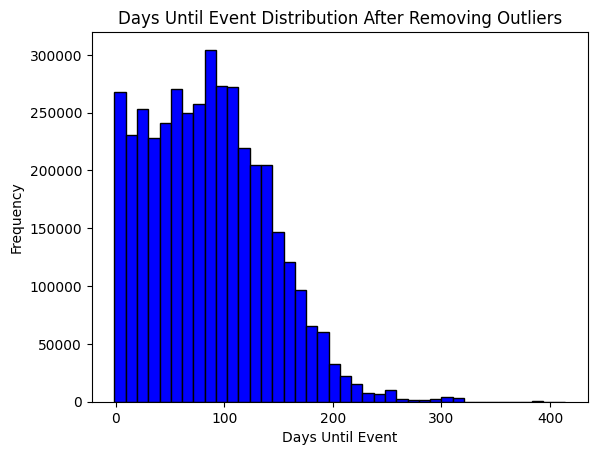

In [142]:
plt.hist(data['days_until_event'], bins=40, color='blue', edgecolor='black')
plt.title('Days Until Event Distribution After Removing Outliers')
plt.xlabel('Days Until Event')
plt.ylabel('Frequency')
plt.show()

In [143]:
data['months_until_event'] = data['days_until_event'] // 30

data['weeks_until_event'] = data['days_until_event'] // 7


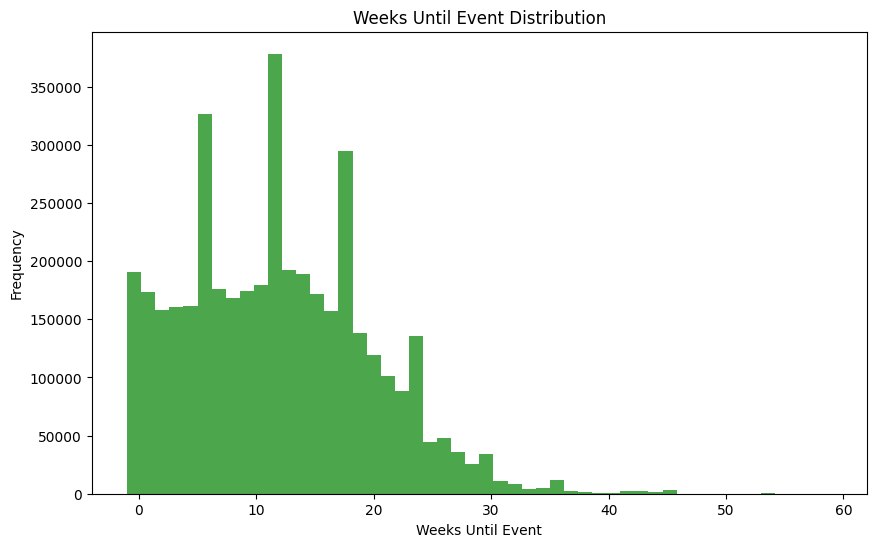

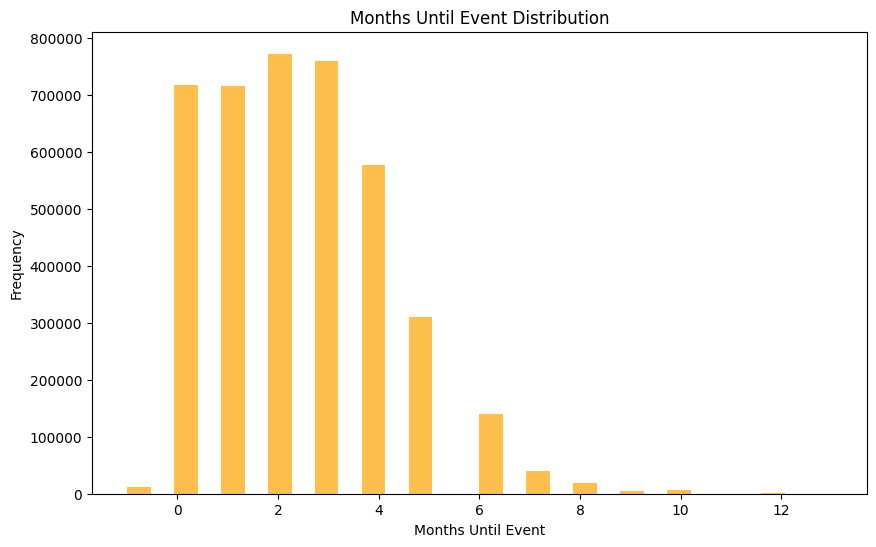

In [144]:
plt.figure(figsize=(10,6))
plt.hist(data['weeks_until_event'], bins=50, color='green', alpha=0.7)
plt.title('Weeks Until Event Distribution')
plt.xlabel('Weeks Until Event')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10,6))
plt.hist(data['months_until_event'], bins=30, color='orange', alpha=0.7)
plt.title('Months Until Event Distribution')
plt.xlabel('Months Until Event')
plt.ylabel('Frequency')
plt.show()

In [148]:
filter_zero_resale = data[(data['availability_resale']==0)]
filter_Nonzero_resale = data[(data['availability_resale']>0)]
print("zero resale tickets :",filter_zero_resale.shape[0])
print("non_zero resale tickets :",filter_Nonzero_resale.shape[0])


zero resale tickets : 2266290
non_zero resale tickets : 1809790


In [149]:

# fig, axs = plt.subplots(1,2,figsize=(10,5))
# sns.scatterplot(x='availability_standard',y='days_until_event',data=filter_zero_resale,ax=axs[0])
# sns.scatterplot(x='availability_standard',y='days_until_event',data=filter_Nonzero_resale,ax=axs[1])

In [150]:
# fig, axs = plt.subplots(1,2,figsize=(10,5))
# sns.scatterplot(x='capacity',y='availability_resale',data=filter_zero_resale,ax=axs[0])
# sns.scatterplot(x='capacity',y='availability_resale',data=filter_Nonzero_resale,ax=axs[1])

In [151]:
data['remaning_tickets'] = data['availability_standard'] + data['availability_resale']
data_cleaned = data[data['remaning_tickets'] <= data['capacity']]

In [152]:
# fig, axs = plt.subplots(1,3,figsize=(15,5))
# sns.scatterplot(x='capacity',y='remaning_tickets',data=data_cleaned,ax=axs[0])
# sns.scatterplot(x='capacity',y='availability_standard',data=data_cleaned,ax=axs[1])
# sns.scatterplot(x='capacity',y='availability_resale',data=data_cleaned,ax=axs[2])

In [153]:
data_cleaned.describe().astype(int)

,show_id,availability_standard,availability_resale,capacity,venue_id,days_until_event,hours_until_event,months_until_event,weeks_until_event,remaning_tickets
count,3853287,3853287,3853287,3853287,3853287,3853287,3853287,3853287,3853287,3853287
mean,4825212,111,13,353,10456,85,2059,2,11,125
std,151719,507,104,1132,9246,54,1306,1,7,522
min,4217851,0,0,1,9,-1,-8,-1,-1,1
25%,4774106,3,0,90,868,41,1006,1,5,9
50%,4856974,22,0,208,11435,82,1978,2,11,38
75%,4933229,103,10,348,21853,122,2938,4,17,114
max,5060180,39784,16312,100000,29084,414,9957,13,59,39784


In [154]:
# fig, axs = plt.subplots(1,3,figsize=(15,5))
# sns.scatterplot(y='days_until_event',x='remaning_trickets',data=data_cleaned,ax=axs[0])
# sns.scatterplot(y='days_until_event',x='availability_standard',data=data_cleaned,ax=axs[1])
# sns.scatterplot(y='days_until_event',x='availability_resale',data=data_cleaned,ax=axs[2])

In [156]:
data_cleaned['eight_per_capacity'] = data_cleaned['capacity']*0.8

C:\Users\DeLL\AppData\Local\Temp\ipykernel_11628\3910882577.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned['eight_per_capacity'] = data_cleaned['capacity']*0.8


In [157]:
data_cleaned['sold_tickets'] = data_cleaned['capacity'] - data_cleaned['remaning_tickets']
sold_ticket_80p = data_cleaned[(data_cleaned['sold_tickets'] > 0.8 * data_cleaned['capacity'])&(data_cleaned['capacity']<20000)]
sold_ticket_80p.shape

C:\Users\DeLL\AppData\Local\Temp\ipykernel_11628\1517182006.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned['sold_tickets'] = data_cleaned['capacity'] - data_cleaned['remaning_tickets']


(1528371, 16)

In [158]:
sold_ticket_80p['sold_percentage'] = ((sold_ticket_80p['capacity'] - sold_ticket_80p['remaning_tickets']) / sold_ticket_80p['capacity']) * 100
show_sold_group = sold_ticket_80p.groupby('show_id')

C:\Users\DeLL\AppData\Local\Temp\ipykernel_11628\1033943429.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sold_ticket_80p['sold_percentage'] = ((sold_ticket_80p['capacity'] - sold_ticket_80p['remaning_tickets']) / sold_ticket_80p['capacity']) * 100


In [159]:
show_list = sold_ticket_80p['show_id'].unique()
last_time_sold = pd.DataFrame([])
for show in show_list:
    show_entrys = show_sold_group.get_group(show)
    current_sold_show = show_entrys[(show_entrys['timestamp']==show_entrys['timestamp'].max())]
    last_time_sold = pd.concat([last_time_sold,current_sold_show],axis=0,ignore_index=True)


In [160]:
highly_sold_shows = last_time_sold[last_time_sold['sold_percentage']>95][['show_id','venue_id','section_id','timestamp', 'event_date', 'remaning_tickets', 'capacity','sold_tickets','sold_percentage','days_until_event','hours_until_event','event_time_zone']]
highly_sold_shows

,show_id,venue_id,section_id,timestamp,event_date,remaning_tickets,capacity,sold_tickets,sold_percentage,days_until_event,hours_until_event,event_time_zone
2,4429735,803,101,2024-06-14 21:10:58+00:00,2024-06-14 19:30:00+00:00,6,260,254,97.692308,-1,-1.682778,America/New_York
3,4429735,803,103,2024-06-14 21:10:58+00:00,2024-06-14 19:30:00+00:00,1,259,258,99.613900,-1,-1.682778,America/New_York
5,4429735,803,108,2024-06-14 21:10:58+00:00,2024-06-14 19:30:00+00:00,4,355,351,98.873239,-1,-1.682778,America/New_York
7,4429735,803,116,2024-06-14 21:10:58+00:00,2024-06-14 19:30:00+00:00,8,322,314,97.515528,-1,-1.682778,America/New_York
8,4429735,803,118,2024-06-14 21:10:58+00:00,2024-06-14 19:30:00+00:00,12,336,324,96.428571,-1,-1.682778,America/New_York
...,...,...,...,...,...,...,...,...,...,...,...,...
16937,4862559,11560,GA,2024-05-31 09:05:08+00:00,2024-06-13 19:00:00+00:00,8,333,325,97.597598,13,321.914444,America/New_York
16938,4726526,22206,ADMISSION GÉNÉRALE,2024-05-04 21:11:08+00:00,2024-05-04 19:00:00+00:00,12,2400,2388,99.500000,-1,-2.185556,America/New_York
16939,4985621,200,BALC,2024-06-03 09:19:51+00:00,2024-08-10 19:00:00+00:00,2,44,42,95.454545,68,1641.669167,America/Los_Angeles
16941,4644199,2355,GA - Standing Room Only,2024-05-10 21:12:12+00:00,2024-05-10 20:00:00+00:00,9,1000,991,99.100000,-1,-1.203333,America/Los_Angeles


C:\Users\DeLL\AppData\Local\Temp\ipykernel_11628\2312297606.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='show_id', y='sold_percentage', data=highly_sold_shows, palette='viridis')


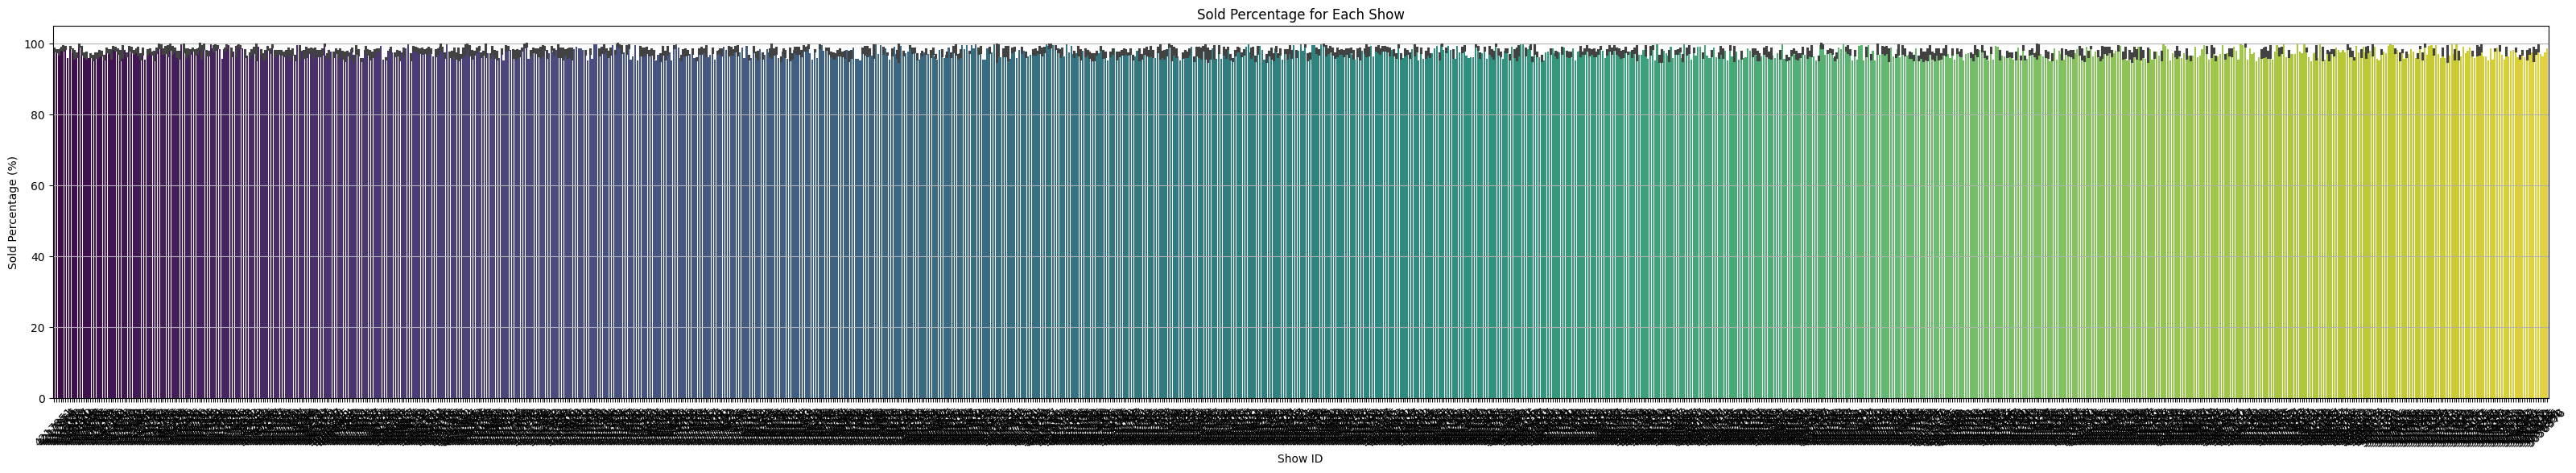

In [161]:
plt.figure(figsize=(40, 6))
sns.barplot(x='show_id', y='sold_percentage', data=highly_sold_shows, palette='viridis')
plt.title('Sold Percentage for Each Show')
plt.xticks(rotation=45)
plt.ylabel('Sold Percentage (%)')
plt.xlabel('Show ID')
plt.grid(axis='y')
plt.show()

C:\Users\DeLL\AppData\Local\Temp\ipykernel_11628\2957698241.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x='event_time_zone', data=highly_sold_shows,bins=30, palette='viridis')


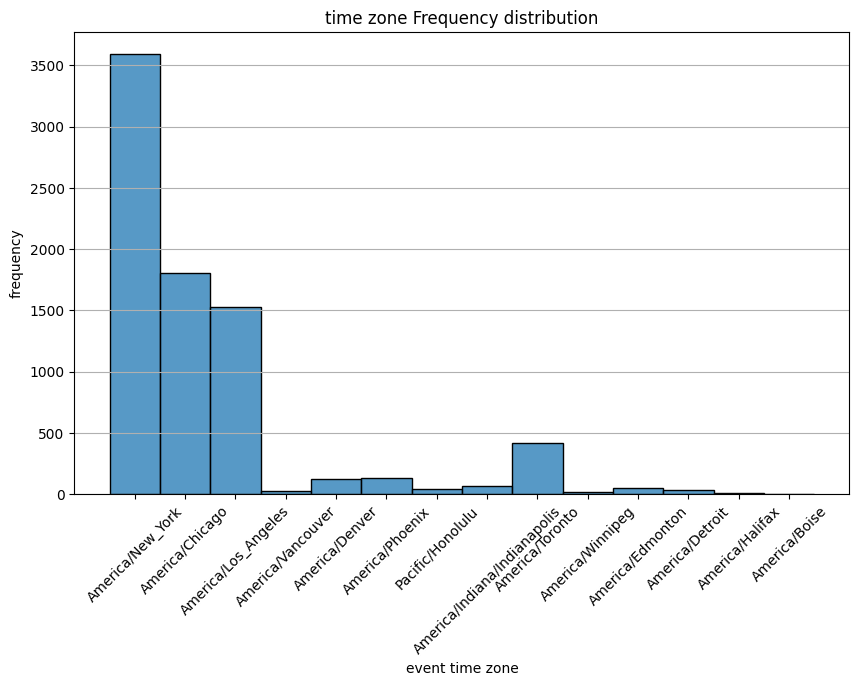

In [162]:
plt.figure(figsize=(10, 6))
sns.histplot(x='event_time_zone', data=highly_sold_shows,bins=30, palette='viridis')
plt.title('time zone Frequency distribution')
plt.xticks(rotation=45)
plt.ylabel('frequency')
plt.xlabel('event time zone')
plt.grid(axis='y')
plt.show()

<Axes: xlabel='sold_tickets', ylabel='capacity'>

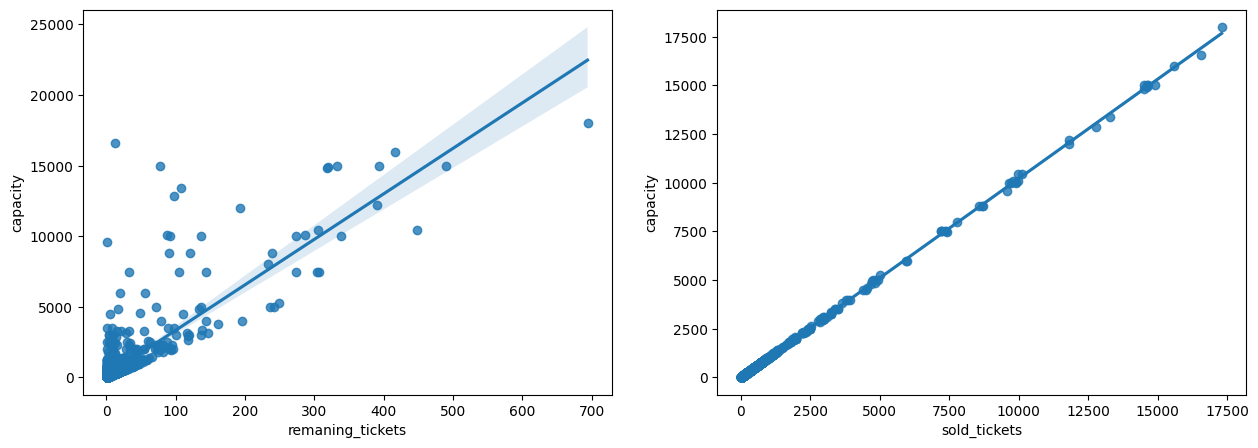

In [163]:
fig, axs = plt.subplots(1,2,figsize=(15, 5))
sns.regplot(y='capacity',x='remaning_tickets', data=highly_sold_shows,x_ci='sd',order=1, ax=axs[0])
sns.regplot(y='capacity',x='sold_tickets', data=highly_sold_shows,x_ci='sd',order=1, ax=axs[1])

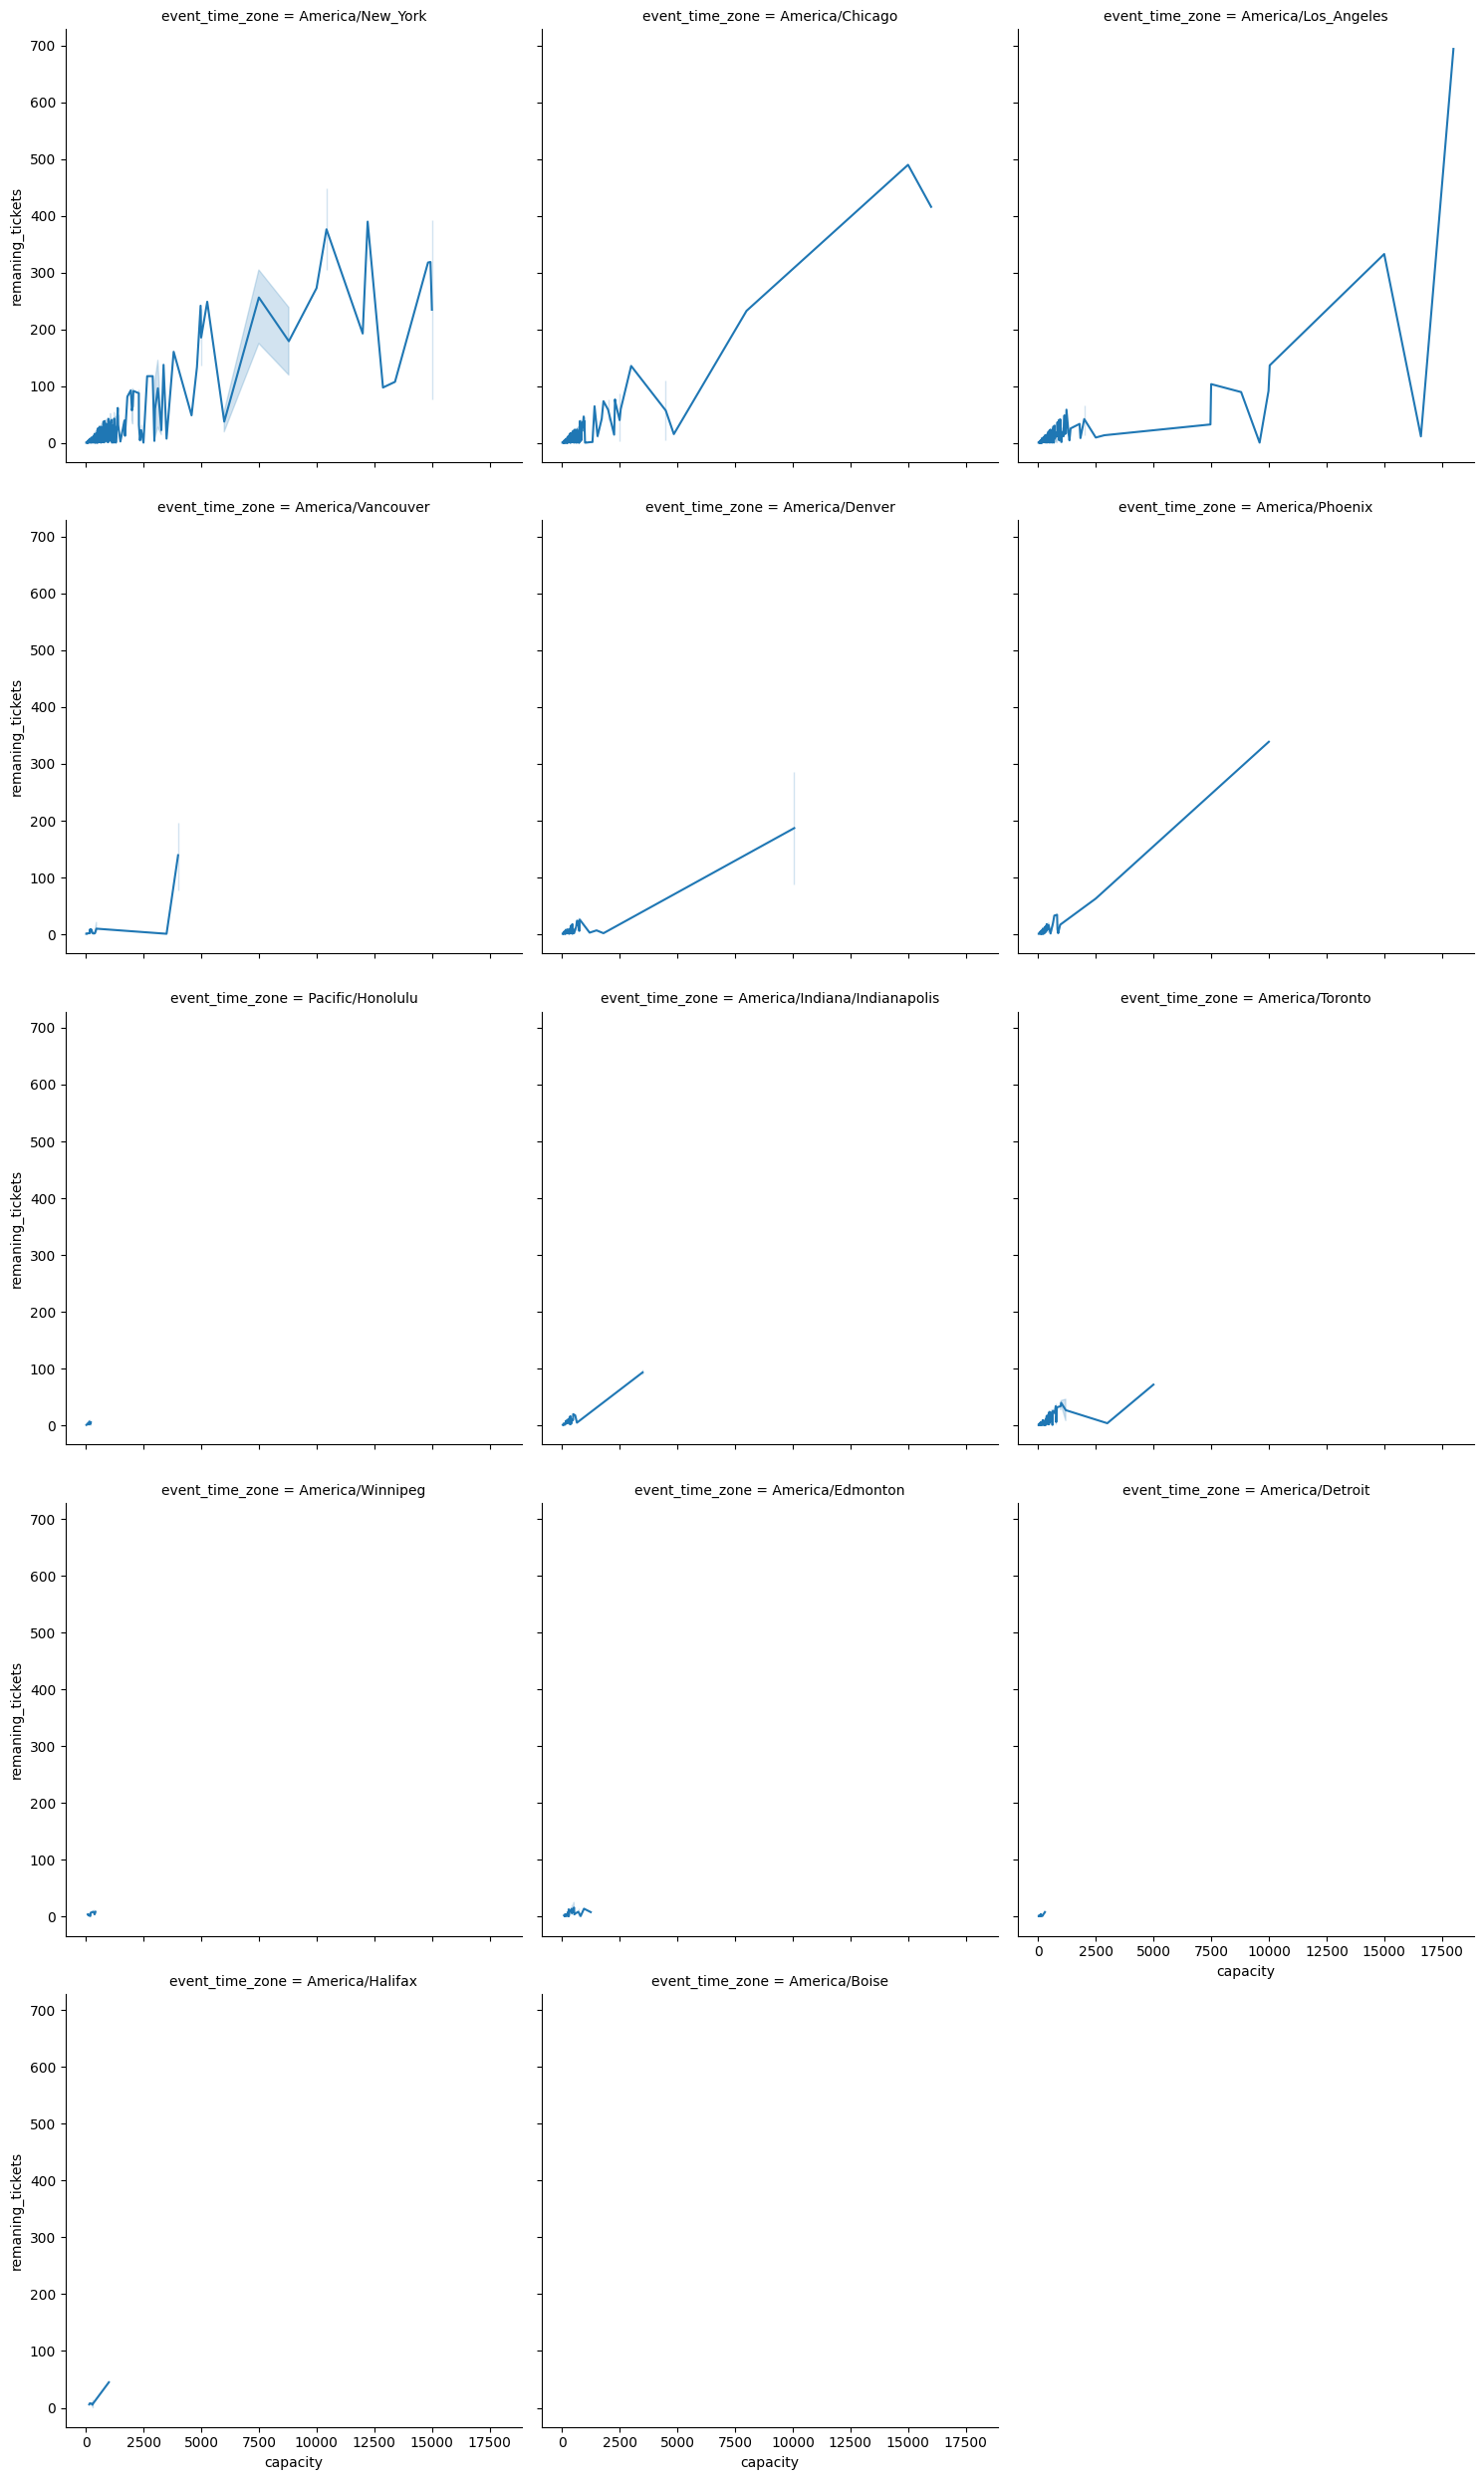

In [164]:
sns.relplot(x='capacity',y='remaning_tickets', data=highly_sold_shows,col='event_time_zone', kind='line',col_wrap=3)

In [165]:
# Total tickets sold across all shows
total_tickets_sold = highly_sold_shows['sold_tickets'].sum()

# Average sold percentage
average_sold_percentage = highly_sold_shows['sold_percentage'].mean()

# Total remaining tickets
total_remaining_tickets = highly_sold_shows['remaning_tickets'].sum()

print(f"Total Tickets Sold: {total_tickets_sold}")
print(f"Average Sold Percentage: {average_sold_percentage:.2f}%")
print(f"Total Remaining Tickets: {total_remaining_tickets}")

Total Tickets Sold: 2863371
Average Sold Percentage: 97.76%
Total Remaining Tickets: 61371


In [166]:
highly_sold_shows.to_csv('higher_sold_event_show.csv')

In [167]:

# Sample DataFrame 'df' contains relevant features including sold_tickets and other predictive features
X = highly_sold_shows[['capacity', 'days_until_event', 'hours_until_event']]
y = highly_sold_shows['sold_tickets']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating and training the model
model = RandomForestRegressor()
model.fit(X_train, y_train)

# Making predictions
y_pred = model.predict(X_test)

# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse:.2f}')


Mean Squared Error: 451.14


In [168]:
print("training score : ", model.score(X_train, y_train))
print("test_score : ", model.score(X_test, y_test))

training score :  0.9996752013254582
test_score :  0.9993361413203484


Mean Absolute Error: 4.93


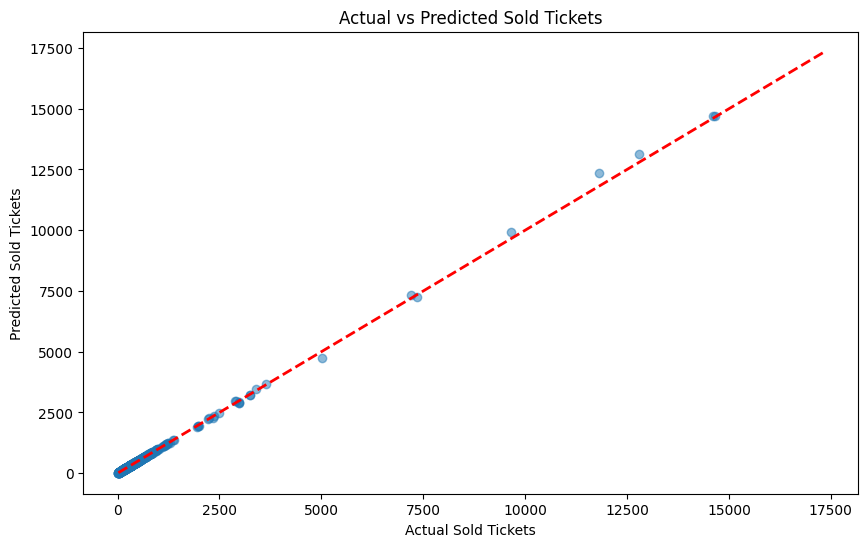

In [169]:
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# Calculate Mean Absolute Error
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae:.2f}')

# Visualizing Predictions vs Actual
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)  # Diagonal line
plt.xlabel('Actual Sold Tickets')
plt.ylabel('Predicted Sold Tickets')
plt.title('Actual vs Predicted Sold Tickets')
plt.show()

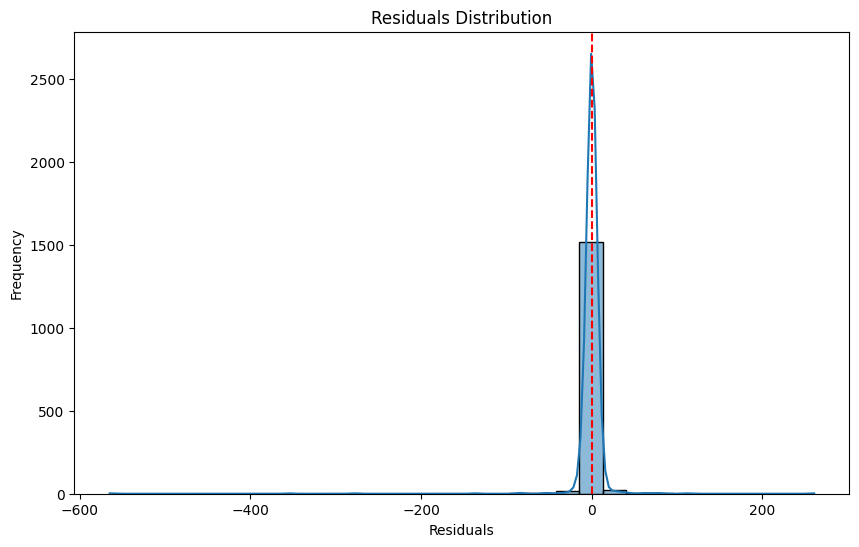

In [170]:
residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=30, kde=True)
plt.title('Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.axvline(0, color='red', linestyle='--')
plt.show()

In [171]:
# Check feature importance from the RandomForestRegressor
feature_importances = model.feature_importances_

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df)

             Feature  Importance
0           capacity    0.998521
2  hours_until_event    0.001281
1   days_until_event    0.000197


In [172]:
import joblib

# Save the model to a file
joblib.dump(model, 'random_forest_model.pkl')

# To load the model back later:
# model = joblib.load('random_forest_model.pkl')

['random_forest_model.pkl']

In [174]:
lr = LinearRegression()
lr.fit(X_train,y_train)

LinearRegression()

In [176]:
y_pred_lr = lr.predict(X_test)
mse = mean_squared_error(y_test, y_pred_lr)
print(f'Mean Squared Error: {mse:.2f}')

Mean Squared Error: 104.99


In [177]:
print("training score : ", lr.score(X_train, y_train))
print("test_score : ", lr.score(X_test, y_test))

training score :  0.9997636679663041
test_score :  0.9998455080091989
